# Competitive Pokemon Analysis

While in the traditional pokemon games, players raise Pokemon to complete an adventure, competitive Pokemon is a game where players strategically construct teams of pokemon with moves, natures, items, etc of their choosing to beaet other live players.  Not all Pokemon are equal for this purpose, so based on the usage statistics of the pokemon in competitive play, they are split into various tiers. A player may use a Pokemon to compete in a particular tier if the pokemon is in that tier or below. Historically, usage of various pokemon has changed overtime with the introduction of new pokemon, moves, abilities, and mechanics. So, Pokemon are constantly shifted between tiers to maintain balance.

In this analysis, we will attempt to classify pokemon into the competitive 6v6 tiers based on the properties of the Pokemon themselves.

TODO:
- Add error bars to average stats factorplot
- Set heatmap y-axis

## Data Processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('pokemon-data.csv', delimiter=';')
mdf = pd.read_csv('move-data.csv', delimiter=';')

print('Number of pokemon: ', len(df))
df.sample()

Number of pokemon:  918


,Name,Types,Abilities,Tier,HP,Attack,Defense,Special Attack,Special Defense,Speed,Next Evolution(s),Moves
381,Kartana,"['Grass', 'Steel']",['Beast Boost'],OU,59,181,131,59,31,109,[],"['Sacred Sword', 'Defog', 'Vacuum Wave', 'Air ..."


The base stat total is a common metric players use to assess a Pokemon's overall strength, so let's create a column for this.

In [4]:
df.columns = ['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'next_evo','moves']
df['bst'] = df['hp'] + df['atk'] + df['def'] + df['spa'] + df['spd'] + df['spe']
df = df[['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst', 'next_evo','moves']]
df.set_index('name', inplace=True)

The next evolution information is not immediately useful; however, we can determine how far a pokemon is in it's evolutionary chain. Notice that a pokemon can have one, two, or three evolutions in it's chain, along with the possibility of a mega evolution. A pokemon that is in its final form that after one evolution is not necessarily weaker or stronger than another after two evolutions. For each pokemon, let's store the length of the evolutionary chain (excluding mega evolutions) and it's stage in the chain. 

A mega evolution will be the stage of the pokemon + 1. For example, Blaziken would have a chain length of 3 and it would be in stage 3, while Mega Blaziken would have a chain length of 3 and it would be in stage 4. 

However, some pokemon have alternate forms listed as evolutions. Consider:

In [5]:
df[df.index == 'Giratina']

,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evo,moves
name,,,,,,,,,,,,
Giratina,"['Dragon', 'Ghost']","['Pressure', 'Telepathy']",Uber,150,100,120,100,120,90,680,['Giratina-Origin'],"['Dragon Breath', 'Scary Face', 'Ominous Wind'..."


We shall treat alternate forms that have a BST that is strictly greater than its original as a mega evolution. Otherwise, it will be treated as equivalent to the original form.

In [6]:
def stage_in_evo(n):
    # returns number of evolutions before it
    #print(df[df['name'] == n]['name'])
    bool_arr = df.apply(lambda x: n in eval(x['next_evo']) and (n+'-') not in x['next_evo'], axis=1) #gets index of previous evolution
    if '-Mega' in n: #mega evolutions
        return stage_in_evo(n.split('-')[0]) + 1 
    elif not any(bool_arr):
        return 1 # if there's nothing before it, it's the first
    else:
        return 1 + stage_in_evo(df.index[bool_arr][0])

def num_evos(n):
    if n not in df.index: #checks to ensure valid pokemon
        return n
    
    next_evos = eval(df.loc[n, 'next_evo'])
    if len(next_evos) > 0: #existence of next_evo
        if n in next_evos[0]: # if "next evo" is an alternate form
            return df.loc[n, 'stage'] #accounting for alternate forms
        else:
            return num_evos(next_evos[0])
    elif '-Mega' in n or n.split('-')[0] in df.index: 
        #this is checking if there is a pokemon with the same root name (e.g. Shaymin vs Shaymin-Sky)
        return df.loc[n.split('-')[0], 'stage']
    else:
        return df.loc[n, 'stage']

In [7]:
df['stage'] = df.apply(lambda x: stage_in_evo(x.name), axis=1)

In [8]:
df['num_evos'] = df.apply(lambda x: num_evos(x.name), axis=1)

In [9]:
df[(df.index == 'Landorus-Therian') | (df.index == 'Landorus') | (df.index == 'Monferno') | (df.index == 'Blaziken-Mega') | (df.index == 'Diglett-Alola')] #test

,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evo,moves,stage,num_evos
name,,,,,,,,,,,,,,
Blaziken-Mega,"['Fire', 'Fighting']",['Speed Boost'],Uber,80,160,80,130,80,100,630,[],"['Flare Blitz', 'Fire Punch', 'High Jump Kick'...",4,3
Diglett-Alola,"['Ground', 'Steel']","['Sand Force', 'Sand Veil', 'Tangling Hair']",LC,10,55,30,35,45,90,265,['Dugtrio-Alola'],"['Sand Attack', 'Metal Claw', 'Growl', 'Astoni...",1,2
Landorus,"['Flying', 'Ground']","['Sand Force', 'Sheer Force']",Uber,89,125,90,115,80,101,600,['Landorus-Therian'],"['Outrage', 'Hammer Arm', 'Fissure', 'Block', ...",1,1
Landorus-Therian,"['Flying', 'Ground']",['Intimidate'],OU,89,145,90,105,80,91,600,[],"['Outrage', 'Hammer Arm', 'Fissure', 'Block', ...",2,1
Monferno,"['Fighting', 'Fire']","['Blaze', 'Iron Fist']",NaN,64,78,52,78,52,81,405,['Infernape'],"['Scratch', 'Leer', 'Mach Punch', 'Mach Punch'...",2,3


As of generation 7, there are 8 playable tiers. From strongest to weakest: Anything Goes (AG), Uber, Overused (OU), Underused (UU), Rarelyused (RU), Neverused (NU), Partiallyused (PU) and Little Cup (LC). There are also unplayable tiers called borderline tiers, suffixed by BL. These serve as banlists for their respective tiers (so these pokemon can only be used in higher tiers). For the purpose of this analysis, we will classify BL pokemon as the tier above.

We will not consider the Little Cup (LC) format, as they are not defined by usage statistics (it involves pokemon that are not evolved but are capable of evolution and can be obtained in the traditional games at level 5). We will also discard the AG tier, as it was created solely for Mega Rayquaza. Both Pokemon that belong to no tier because they are uncompetitive and pokemon in the Limbo tier becuase they are unreleased will not be considererd.

Let's make these changes. Also, we shall number the tiers to make plotting easier (lower number => better tier)

In [10]:
df.loc[df.tier == 'OUBL','tier'] = 'Uber'
df.loc[df.tier == 'UUBL','tier'] = 'OU'
df.loc[df.tier == 'RUBL','tier'] = 'UU'
df.loc[df.tier == 'NUBL','tier'] = 'RU'
df.loc[df.tier == 'PUBL','tier'] = 'NU'
df = df[df['tier'].isin(['Uber', 'OU', 'UU', 'NU', 'RU', 'PU'])]

In [542]:
tiers = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU']
tier_mapping = {tier:num for num, tier in enumerate(tiers)}
df['tier_num'] = df.apply(lambda x: tier_mapping[x['tier']], axis=1)
tier_mapping

{'NU': 4, 'OU': 1, 'PU': 5, 'RU': 3, 'UU': 2, 'Uber': 0}

## Exploratory Data Analysis

Let's explore some of the relationships in this data. First, the distribution of the classes:

Total number of Pokemon:  552


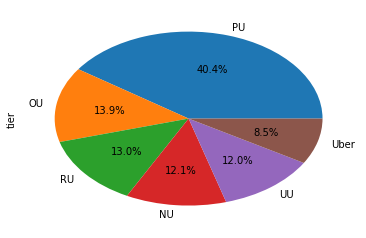

In [12]:
ax = df.tier.value_counts().plot(kind='pie', autopct='%1.1f%%')
print('Total number of Pokemon: ', len(df))

All the upper tiers are similar in size by design, but the PU tier is a dump of all the least used pokemon. We must account for this later. 

Let's examine how the the average stats compare for each tier:

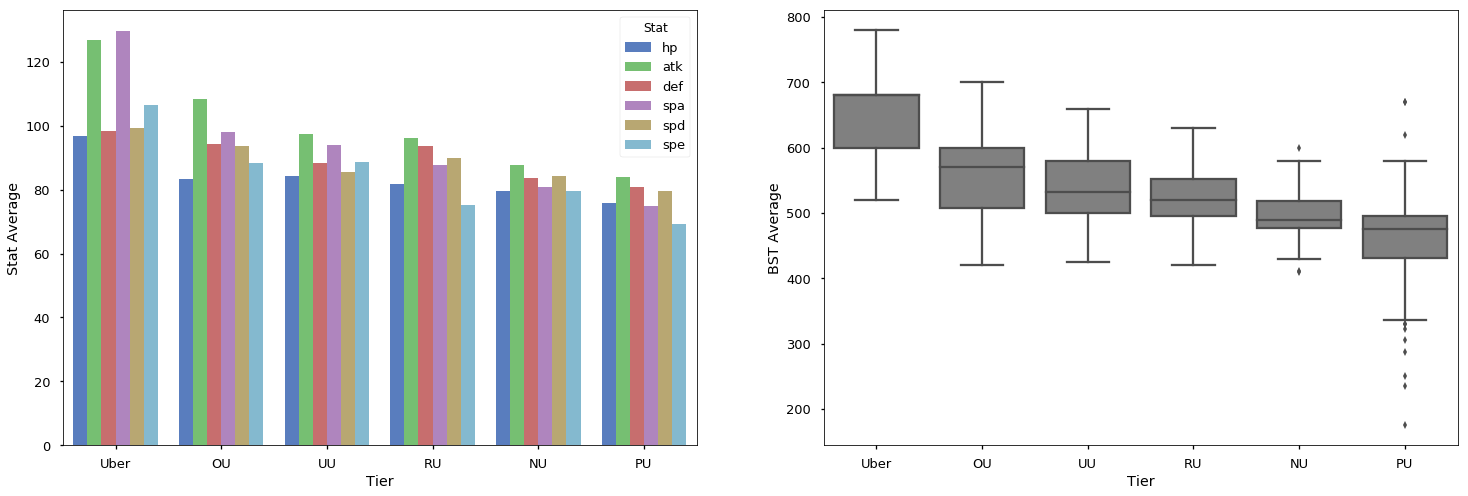

In [180]:
stats_df = df[['tier', 'tier_num', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst']].groupby(['tier', 'tier_num']).agg(np.mean)
stats_df = temp.reset_index()
stats_df = temp.melt(id_vars=['tier', 'tier_num']).sort_values('tier_num', ascending=True)
stats_df.columns = ('Tier', 'tier_num', 'Stat', 'Average')

sns.set_context('talk')
fig, ax = plt.subplots(1,2, figsize=(25,8))
g = sns.factorplot(x="Tier", y="Average", hue_order=['hp', 'atk', 'def', 'spa', 'spd', 'spe'], hue="Stat", 
                 data=stats_df, kind="bar", palette="muted", ax=ax[0])
g2 = sns.boxplot(data=df, x='tier', y='bst', order=tiers, color='grey', ax=ax[1])
#g2=sns.factorplot(x="Tier", y="Average", hue_order=['bst'],hue="Stat", data=temp2,
#                   kind="bar", palette="muted", aspect=1.5,  ax=ax[1])
ax[0].set(xlabel='Tier', ylabel='Stat Average')
ax[1].set(xlabel='Tier', ylabel='BST Average')
plt.close(g.fig)
#plt.close(g2.fig)

Note the different scales. As expected, there is a correlation between how the level of the tier and the pokemon's stats. Interestingly, attack and special attack stats tend to become more prominent in the higher tiers, indicating a more offensive playstyle in these tiers. Also, RU seems to have a lower average speed than NU but higher defensive stats than UU, indicating a particularly defensive playstyle in this tier. Looking at the BST, however, there is much variance in the totals, especially outside of Ubers. This will make classification using stats more difficult.

In competitive pokemon, there are various user-made classifications of pokemon that describe the distribution of their stats and typical movesets. For example, a pokemon with high special/attack and speed stats is typically a sweeper; high HP and defense(s) is a wall; high special/attack and reasonable defenses with low speed is a tank; and etc. 

All the tiers tend to have all the different classifications, so it is unlikely that we will be able to cluster based on stats alone. Let's use Principal Component Analysis to plot all the stats onto a 2D scatter plot to see if this is true.

Variation per principal component: [0.28036344 0.2397493  0.1916674  0.13833584 0.09038911 0.05949491]


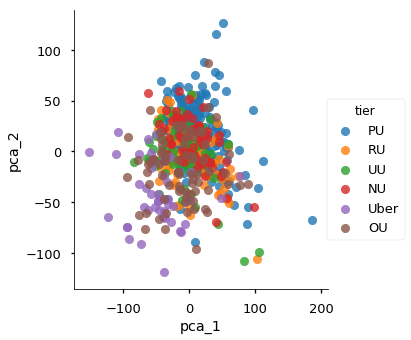

In [182]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca_result = pca.fit_transform(df[['hp', 'atk', 'def', 'spa', 'spd', 'spe']].values)
df['pca_1'] = pca_result[:,0]
df['pca_2'] = pca_result[:,1] 
print(f'Variation per principal component: {pca.explained_variance_ratio_}')
g = sns.lmplot(data = df, x='pca_1', y='pca_2', hue='tier', fit_reg=False)

The first two components make up about 52% of the variance; however, as expected, it is hard to distinguish any meaningful relationships. Though there some information, as the weakest tier, PU, dominates the bottom left while the highest tier, Uber, dominates the upper right. This likely represents the magnitude of the stats of the pokemon in those tiers moreso than the distributions themselves.

Moving away from the pokemon stats, let's look at the types. Both Pokemon can have one or two types while moves have one type. A  move of a given type can be super effective (2x damage), effective (1x damage), not very effective (0.5x damage), or ineffective (0x damage) against another type. When a pokemon has two types, this effect can be compounded (ie 4x damage or 0.25x damage). This is summarized in the table below from https://rankedboost.com/pokemon-sun-moon/type-chart/:

<img src="type-chart.jpg">

This means that certain types and type combinations are advantageous defensively and/or offensively. Let's create a heatmap of the overall distribution of type combinations for pokemon, then heatmaps describing the distribution relative to the overall distribution.

[Text(0.5,1,'Frequency of Type Combinations')]

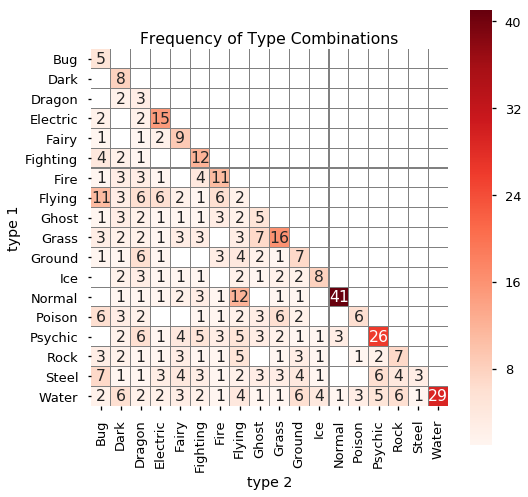

In [295]:
df['type 1'] = df.apply(lambda x: sorted(eval(x['types']))[0], axis=1)
df['type 2'] = df.apply(lambda x: sorted(eval(x['types']))[-1], axis=1) #if a pokemon has a single type, type 2 = type 1

type_df = df[['type 2', 'type 1']].groupby(['type 2', 'type 1']).size().reset_index()
type_df.columns = ['type 1', 'type 2', 'count']
type_pivoted_df = type_df.pivot('type 1', 'type 2', 'count')

plt.subplots(figsize=(8,8))
sns.heatmap(type_pivoted_df, annot=True, square=True, cmap='Reds', linecolor='grey', linewidths='0.05')
plt.gca().set(title='Frequency of Type Combinations')


This alone is not particularly interesting, except for the fact that purely Normal, Water, and Psychic type pokemon are very common. With a much larger dataset, the frequencies per tier would be interesting, but on this small set with many unique type combinations, the frequencies per tier would not contain much information. Instead, let's look at the overall frequencies of individual types:

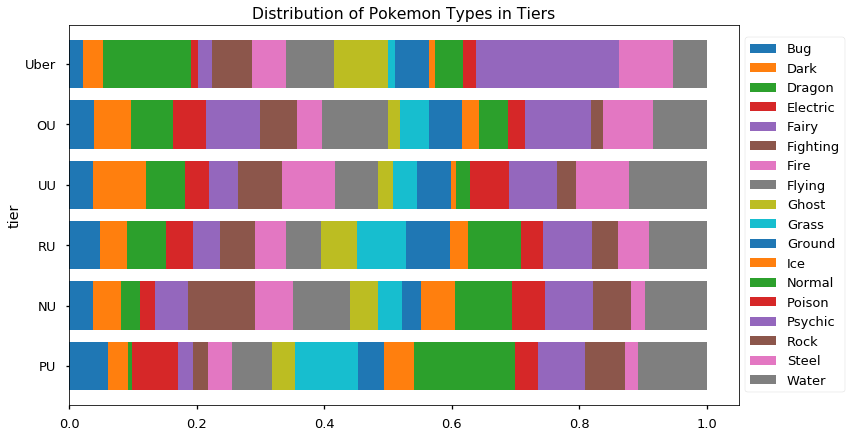

In [591]:
#Get individual counts of type1 and type 2
type1_count = df[['tier', 'type 1']].groupby(['tier', 'type 1']).size().reset_index()
type2_count = df[['tier', 'type 2']].groupby(['tier', 'type 2']).size().reset_index()
type1_count.columns=['tier', 'type', 'count1']
type2_count.columns=['tier', 'type', 'count2']

#Get overall type frequency per tier
type_count = pd.merge(type1_count, type2_count, on=['tier', 'type'], how='outer')
type_count.fillna(value=0, inplace=True)
type_count['count'] = type_count['count1'] + type_count['count2']
type_count_ind = type_count.set_index(['tier','type'])
type_count['count'] = type_count.apply(lambda x: x['count']/np.sum(type_count_ind.loc[x['tier'], 'count'])
                                      , axis=1) # /np.sum(type_count_ind2.loc[x['tier'], 'count'])

#Format Table and Sort rows
type_count = type_count[['tier','type','count']]
type_count = type_count.set_index(['tier','type']).unstack()['count']
type_count['tier_nums'] = type_count.apply(lambda x: tier_mapping[x.name],axis=1)
type_count = type_count.sort_values(by='tier_nums', ascending=False)
del type_count['tier_nums']

#Plit
type_count.plot.barh(stacked=True, title='Distribution of Pokemon Types in Tiers', 
                     legend=False, figsize=(12, 7), sort_columns=True, width=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

The stronger the tier, the more prominent dragon, psychic, and steel types are. The weaker the tier, the more prominent normal and grass types are. The distribution of steel, dragon, and grass types can be partly explained by their type advantages: dragon is an effective offensive type, steel is an effective defensive type, and grass is poor at both. However, this distribution is caused by the bias of the game developers. For example, "legendary" pokemon tend to be part dragon or psychic types.